# **Dependencies**

In [27]:
from collections import Counter
import pandas as pd
import numpy as np
import timeit
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random
import argparse
from operator import itemgetter
from itertools import combinations, product
from itertools import tee
from itertools import islice
from scipy.stats import entropy


# **BWT, MTF and Entropy**

In [28]:
def entropy_shannon(s, base=None):
    value, counts = np.unique(s, return_counts=True)
    return entropy(counts, base = base)

def bw_transform(s):
    n = len(s)
    m = sorted([s[i:n]+s[0:i] for i in range(n)])
    I = m.index(s)
    L = [q[-1] for q in m]
    return (I, L)


def bw_restore(I, L):
    n = len(L)
    X = sorted([(i, x) for i, x in enumerate(L)], key=itemgetter(1))

    T = [None for i in range(n)]
    for i, y in enumerate(X):
        j, _ = y
        T[j] = i

    Tx = [I]
    for i in range(1, n):
        Tx.append(T[Tx[i-1]])

    S = [L[i] for i in Tx]
    S.reverse()
    return ''.join(S)

common_dictionary = list(range(256))
def encodeMTF(plain_text):      
    # Changing the common dictionary is a bad idea. Make a copy.
    dictionary = common_dictionary.copy()
    
    compressed_text = list()    
    rank = 0

    # Read in each character
    for c in plain_text:
        rank = dictionary.index(int(c))   
        compressed_text.append(rank) 

        dictionary.pop(rank)
        dictionary.insert(0, int(c))

    return compressed_text

def decodeMTF(compressed_data):
    compressed_text = compressed_data
    dictionary = common_dictionary.copy()
    plain_data = []

    for rank in compressed_text:

        plain_data.append(dictionary[rank])

        e = dictionary.pop(rank)
        dictionary.insert(0, e)

    return plain_data    

# **HUFFMAN CODING CLASS**

In [29]:
from collections import Counter

class NodeT:

	def __init__(self, frequency, left, right, isLeaf, valueLeaf):
         self.frequency = frequency
         self.left = left
         self.right = right
         self.isLeaf = isLeaf
         self.valueLeaf = valueLeaf

	def getLeft(self):
		return self.left

	def getRight(self):
		return self.right

	def F(self):
		return self.frequency

	def V(self):
		return self.valueLeaf

class Huffman:
  def __init__(self, fileBytes):
    self.fileBytes = fileBytes
    self.huffmancodes = {}
    self.codes = []
    self.compressedFile = None
    self.tablefrequency = {}
    self.realLength = 0
    self.remained=0
    self.base_table = None

  def compress(self):  

      self.realLength = len(self.fileBytes)

      c = dict(Counter(self.fileBytes))
          
      for key, value in c.items():
            self.tablefrequency[key] = value                                        
      tl = []
      lk  = self.tablefrequency.keys()             
      
      for k in lk:          
          n  = NodeT(self.tablefrequency.get(k),None, None, True, k)
          tl.append(n)                
                
      tl.sort(key=lambda x: x.frequency)
                  
      while len(tl)> 1:          
          l = tl.pop(0)          
          r = tl.pop(0)          
          tn = NodeT(l.F() + r.F() ,l, r, False, None)     
          tl.append(tn)
          tl.sort(key=lambda x: x.frequency)
                  
      self._huffmanCodes(tl.pop(0))            
            
      cf = []
      for b in self.fileBytes:
          cf.append(self.huffmancodes.get(b))  
      
      self.compressedFile = ''.join(cf)
      #Returning the huffman table, new bytes compressed, remaining in bits
      #return self.huffmancodes, ''.join(cf), remained
    
  def _huffmanCodes(self, tl):       
      if tl.isLeaf == False:         
         l = tl.getLeft()
         r = tl.getRight()
         self.codes.append("0")
         self._huffmanCodes(l);
         self.codes.pop()
         self.codes.append("1")
         self._huffmanCodes(r) 
         self.codes.pop()
      else:                        
         self.huffmancodes[tl.V()] = ''.join(self.codes)       
      
    
  def details_compression(self):
    raw = self.realLength * 8
    compressed = len(self.compressedFile)    
    percent = ((compressed * 100) / raw)
    return ((float)(100 - percent))

  def _table(self):
     _byte =  list(self.huffmancodes.keys())
     _symbol = [chr(b) for b in _byte]
     _codigo =  list(self.huffmancodes.values())
     _frequency = [self.tablefrequency[b] for b in _byte]
     _length_code = [len(c) for c in _codigo]
     _length_byte = [len(str(c)) for c in _byte]
     _start_byte = [int(str(c)[:1]) for c in _byte]

     self.base_table = pd.DataFrame(list(zip(_byte, _symbol, _codigo, _length_code, _length_byte, _start_byte, _frequency )), 
               columns =['Byte', 'Symbol', 'Code', 'Length_code', 'Length_Byte', 'Start_Byte', 'Frequency'])     
               
  def info_table(self):
      self._table()
      lc_count = dict(Counter(list(self.base_table['Length_code'])))
      result = self.base_table.groupby('Length_code', as_index=False).agg({"Frequency": "sum"})
      _count = [ lc_count[l] for l in result['Length_code']]
    
      length_code = list(result['Length_code'])
      return pd.DataFrame(list(zip(list(result['Length_code']), _count, list(result['Frequency']) )), index=length_code, 
                columns =['Longitud Código', 'Numero de Códigos', 'Total Bytes'])  



# **PLOTING CODING**

In [30]:
# Function that plots the bytes encoded by a family type by length

def plot_lens_by_codes_families(term_freq, hf_code):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (28, 6))

    bars = []
    values= []
    for ix in range(256):
        if ix in term_freq.keys():
            bars.append(ix)
            values.append(term_freq[ix])
    y_pos = np.arange(len(bars))

    # Vertical barchart
    barlist = plt.bar(y_pos, values, alpha = 0.7)
    plt.xticks(y_pos, bars, rotation=45)

    sum_values = sum(values)
    # Add bar labels
    lens = []
    for i, v in enumerate(values):
        key = bars[i]
        length = len(hf_code[key])
        l = str(round((v / sum_values) * 100, 1)) + '%'
        if v > 100:
            ax.text((i - 0.6), (v * 1.0125), str(l), color = "black", fontweight = "normal", fontsize = 7)
        barlist[i].set_color(palette[str(length)])

    # Add custom legend
    legend_list = []
    for k, v in palette.items():
        legend_list.append(mpatches.Patch(color = v, label = 'Longitud código ' + k))

    plt.legend(handles = legend_list)
    plt.ylabel('Frecuencia')
    plt.xlabel('# Bytes')
    plt.title('Longitudes por familia de códigos')
    plt.grid(False)
    plt.show()

def plot_fails_trend(_dataf, _datas, title):    
    f_mean = stats.mean(_dataf)
    f_stdev = stats.pstdev(_dataf)
    print(round(f_mean, 4), 'fallos/byte con desviación estándar:', round(f_stdev, 4))

    max_value = max(_dataf)
    min_value = 0
    upper_lim = min(max_value, (f_mean + f_stdev))
    lower_lim = max(min_value, (f_mean - f_stdev))
    
    fig = plt.figure(figsize = (24, 5))
    plt.plot(_dataf, linewidth=1, marker='.', markersize=5, color= '#f38d8b', label= "fallos")    
    plt.plot(_datas,  linewidth=1, marker='.', markersize=5, color= '#20639B', label= "longitud de código")
    plt.grid(alpha=.4)
    plt.legend()
    plt.axhline(y = upper_lim, color = "#000000", linestyle = "--", linewidth=1)
    plt.axhline(y = f_mean, color = "#000000", linestyle = "-", linewidth=1)
    plt.axhline(y = lower_lim, color = "#000000", linestyle = "--", linewidth=1)
    plt.title('Comportamiento del fallo durante la decodificación (' + title + ')')
    plt.xlabel('# Tiempo', fontsize = 10)
    plt.ylabel('Cantidad de fallos / longitud de código encontrada', fontsize = 10)
    # plt.xticks(list(range(0,len(_dataf))), rotation=60)    
    plt.tick_params(axis="x", labelsize=10)
    
    
    plt.show()

def plot_fails_violin(violindf, xname, yname):

    fig, ax = plt.subplots(1, 1, figsize = (15, 8))

    sns.set(style="whitegrid")
    sns.violinplot(xname, yname, data = violindf, color='#f8bab9', linewidth=2)
    sns.stripplot(xname,yname, data=violindf, jitter=True, color='#f38d8b' ,size=6, marker="D", edgecolor="black", alpha=.25 , zorder=1)                   
    ax.set_xlabel('')
    ax.set_ylabel('# fallos', fontsize = 10)
    plt.title('Distribución del numero de fallos')
    plt.show()   



def plot_fails_dist(fd1,fd2,fd3,fd4):

    fig = plt.figure(figsize = (24, 12))
    fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 4])     

    x = min(fd1['n_fails'])    
    
    ax1 = plt.subplot(gs[0])
    g = sns.barplot(x = 'n_fails', y = 'quantity', data = fd1, color='#6699cc')

    for index, row in fd1.iterrows():
        lbl_value = str(round(row.fails_perc, 4)) + ' %'        
        g.text(row.n_fails - x, row.quantity * 1.02 , lbl_value, color='black', ha="center", fontsize = 8)

    ax1.set_xlabel('# Fallos', fontsize = 9)
    ax1.set_ylabel('Número de fallos', fontsize = 9)

    x = min(fd2['n_fails'])    
    
    ax2 = plt.subplot(gs[1])
    g = sns.barplot(x = 'n_fails', y = 'quantity', data = fd2, color='#6699cc')

    for index, row in fd2.iterrows():
        lbl_value = str(round(row.fails_perc, 4)) + ' %'        
        g.text(row.n_fails - x, row.quantity * 1.02 , lbl_value, color='black', ha="center", fontsize = 8)

    ax2.set_xlabel('# Fallos', fontsize = 9)
    ax2.set_ylabel('Número de fallos', fontsize = 9)

    
    x = min(fd3['n_fails'])        
    ax3 = plt.subplot(gs[2])
    g = sns.barplot(x = 'n_fails', y = 'quantity', data = fd3, color='#6699cc')

    for index, row in fd3.iterrows():
        lbl_value = str(round(row.fails_perc, 4)) + ' %'        
        g.text(row.n_fails - x, row.quantity * 1.02 , lbl_value, color='black', ha="center", fontsize = 8)

    ax3.set_xlabel('# Fallos', fontsize = 9)
    ax3.set_ylabel('Número de fallos', fontsize = 9)


    x = min(fd4['n_fails'])    
    
    ax4 = plt.subplot(gs[3])
    g = sns.barplot(x = 'n_fails', y = 'quantity', data = fd4, color='#6699cc')

    for index, row in fd4.iterrows():
        lbl_value = str(round(row.fails_perc, 4)) + ' %'        
        g.text(row.n_fails - x, row.quantity * 1.02 , lbl_value, color='black', ha="center", fontsize = 8)

    ax4.set_xlabel('# Fallos', fontsize = 9)
    ax4.set_ylabel('Número de fallos', fontsize = 9)


    # x = min(fd5['n_fails'])    
    
    # ax5 = plt.subplot(gs[4])
    # g = sns.barplot(x = 'n_fails', y = 'quantity', data = fd5, color='#6699cc')

    # for index, row in fd5.iterrows():
    #     lbl_value = str(round(row.fails_perc, 3)) + ' %'        
    #     g.text(row.n_fails - x, row.quantity * 1.02 , lbl_value, color='black', ha="center", fontsize = 8)

    # ax5.set_xlabel('# Fails', fontsize = 9)
    # ax5.set_ylabel('Number of fails', fontsize = 9)      

    plt.show()      

def table_fails_dist(fails_data):
    fails_dist = Counter(fails_data)
    df_fails_dist = pd.DataFrame.from_records(fails_dist.most_common(), columns = ['n_fails', 'quantity'])
    df_fails_dist["fails_perc"] = 100 * df_fails_dist.quantity / len(fails_data)
    df_fails_dist = df_fails_dist.sort_values(by=['n_fails'])
    return df_fails_dist

def get_accuracy(fails_data, len_des):

    accuracy = 0
    total_attempts = sum(fails_data)
    attempts_dict = dict(Counter(fails_data))

    if 0 in attempts_dict.keys():        
        accuracy = round(100 * len_des / (total_attempts + attempts_dict[0]), 4)
    else:
        accuracy = round(100*len_des / total_attempts,4)

    return accuracy, total_attempts



# ***Section***

In [ ]:

# files = ['book1-en.txt', 'book2-es.txt','tweets_en.json', 'tweets_es.json',  'Homo sapiens chromosome X.fasta', 'Homo sapiens chromosome Y.fasta', 'SARS-CoV-2.fasta', 'Información en el universo holográfico.txt','texto-corto.txt', 'short-text.txt']

# files = ['Homo sapiens chromosome Y.fasta', 'tweets_es.json']#'book1-en.txt', 'book2-es.txt', 'SARS-CoV-2.fasta', 'Información en el universo holográfico.txt','texto-corto.txt', 'short-text.txt']

# fl = []
# longs = []
# ent = []
# minn = []
# gana = []
# chunk= []


# for f in files:
#     print(f)
#     with open('data/' + f, 'rb') as r:                          
#             original= bytearray(r.read())
                    
#     originalVector = [x for x in original]

#     if (len(originalVector) >= 1000000):
#         chunk_size = 4000
#     elif (len(originalVector) < 1000000 and len(originalVector) >= 100000):
#         chunk_size = 5000
#     elif (len(originalVector) < 100000 and len(originalVector) >= 10000):
#         chunk_size = 3000
#     else:
#         chunk_size = len(originalVector)

#     slices_originalVector = [originalVector[i:i + chunk_size] for i in range(0, len(originalVector), chunk_size)]

#     bw_ids = []
#     newvector = []

#     for  sc in slices_originalVector:
#         i, bw_slice = bw_transform(sc)
#         # bw_ids.append(i)
#         newvector.extend(bw_slice)

#     originalVector  = encodeMTF(newvector)

#     l = len(originalVector)
#     h = entropy_shannon(originalVector, 2) 
#     minb = (l*h)/8
#     gan = (l-minb)/l
#     fl.append(f)
#     longs.append(l)
#     ent.append(h)
#     minn.append(minb)
#     gana.append(gan)
#     chunk.append(chunk_size)


# results = pd.DataFrame(list(zip(fl, longs, ent, minn,gana, chunk )),
#                         columns=['File',
#                                 'longitud',
#                                 'entropia',
#                                 'minimo',
#                                 'ganancia',
#                                  'chunk']) 

# results


# **FILE**

In [ ]:
file_name = 'short-text.txt'
with open('data/' + file_name, 'rb') as r:                                                           
          original= bytearray(r.read())
                    
originalVector = [x for x in original]

# slices_originalVector = [originalVector[i:i + 1000] for i in range(0, len(originalVector), 1000)]  

# bw_ids = []
# newvector = []

# for  sc in slices_originalVector:
#     i, bw_slice = bw_transform(sc)
#     bw_ids.append(i)
#     newvector.extend(bw_slice)


# originalVector  = encodeMTF(newvector)

In [ ]:

# term_freq = Counter(originalVector)
# n = len(term_freq)

# N = sum(term_freq.values())
# for term in term_freq:
#     term_freq[term] = term_freq[term] / N

# # Create a temp dataframe
# df = pd.DataFrame.from_records(term_freq.most_common(n), columns = ['Byte', 'Frecuencia'])

# def get_x_labels(s_v):
#     x_labels = []
#     for ix in range(len(s_v)):
#         if ix % 5 == 0:
#             x_labels.append(str(ix))
#         else:
#             x_labels.append('')
#     return x_labels


# # Plot the frequency of the bytes in the file
# fig = plt.figure(figsize = (18, 6))
# ax = sns.barplot(x = 'Byte', y = 'Frecuencia', data = df.sort_values(by=['Byte']), palette=("Blues_r"))
# plt.xticks(fontsize = 10, rotation = 60)
# # ax.set_xticklabels(labels = get_x_labels(set(originalVector)), fontsize = 10, rotation = 50)
# plt.title('Frecuencia de los bytes en ' + file_name )
# plt.show()

# **Algorithms**

In [31]:
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
                           
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}

    def fix_p(self, p):
        if p.sum() != 1.0:
            p = p*(1./p.sum())
        return p                           
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.fix_p(self.transition_matrix[self.index_dict[current_state], :])
        )

 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

class lookup_decoding:

    def __init__(self, cf, ht):
        self.cf = cf
        self.ht = ht

    def decode(self):
        o_file = []
        f_list = []
        s_list = []
        c_size = len(self.cf)        
        buffer = []
        attempts = 0

        for i in range(0, c_size):            
            buffer.append(self.cf[i])
            possible_code = ''.join(buffer)
            if possible_code in self.ht.keys():
                o_file.append(self.ht[possible_code])
                s_list.append(len(possible_code))
                f_list.append(attempts)
                buffer.clear()
                attempts = 0
                continue
            attempts  += 1
                
        return o_file, f_list, s_list

class length_code_decoding:

    def __init__(self, cf, ht, lc):
        self.cf = cf
        self.ht = ht
        self.lc = lc

    def decode(self):
        o_file = []
        f_list = []
        s_list = []
        c_size = len(self.cf)     

        index = 0
        while index < c_size:
            attempts = 0
            for sz in self.lc:
                possible_code = self.cf[index: index + sz]
                if possible_code in self.ht.keys():
                    o_file.append(int(self.ht[possible_code])) 
                    index = index + sz
                    f_list.append(attempts)
                    s_list.append(sz)
                    break
                attempts += 1
                
        return o_file, f_list, s_list

class information_decoding:

    def __init__(self, cf, ht, lc):
        self.cf = cf
        self.ht = ht
        self.lc = lc
        # self.count_whole = {}       
        # self.count_whole.update( [(l, t['total_bytes'][l]) for l in t['length_code']])

    def decode(self):
        o_file = []
        f_list = []
        s_list = []
        c_size = len(self.cf)

        index = 0
        while index < c_size:
            attempts = 0
            for sz in self.lc:
                possible_code = self.cf[index: index + sz]
                if possible_code in self.ht.keys():
                    o_file.append(self.ht[possible_code])
                    f_list.append(attempts)
                    s_list.append(sz)
                    index += sz
                    # self.count_whole[sz] -= 1                         
                    # if self.count_whole[sz] == 0:
                    #     self.lc.remove(sz)             
                    break
                attempts += 1
                
        return o_file, f_list, s_list

class MKC_decoding:

    def __init__(self, cf, ht, lc, mtx):
        self.cf = cf
        self.ht = ht
        self.lc = lc
        self.mtx = mtx

    def decode(self):
        o_file = []
        f_list = []
        s_list = []
        c_size = len(self.cf)

        predict_length = MarkovChain(transition_matrix=self.mtx , states=self.lc)

        #find the first stage (code length)
        next_state_length = 0
        attempts = 0
        for sz in self.lc:
            possible_code = self.cf[0: sz]
            if possible_code in self.ht.keys():
                o_file.append(self.ht[possible_code])
                f_list.append(attempts)
                s_list.append(sz)
                next_state_length= sz                
                break
            attempts += 1

        index = next_state_length
        while index < c_size:
                next_state_length = predict_length.next_state(current_state=next_state_length)
                possible_code = self.cf[index: index + next_state_length]
                if possible_code in self.ht.keys():
                        o_file.append(self.ht[possible_code])
                        f_list.append(attempts)
                        s_list.append(next_state_length)
                        index += next_state_length
                        # next_state_length= next_states_length
                        attempts = 0                  
                else:
                    attempts +=1

        
        return o_file, f_list, s_list        

# class bidireccional_decoding:

#     def __init__(self, cf, ht, lc):
#         self.cf = cf
#         self.ht = ht
#         self.lc = lc
#         o_file = []
#         f_list = []
#         c_size = len(self.cf)

#     def __reverse_slicing(self, s):
#         return s[::-1]

#     def __decoding(self, id_t, c, is_inv):
#         o_file = []
#         f_list = []
#         s_list = []        
#         index = 0

#         if is_inv:

#         else:

#             while index < len(c):
#                 attempts = 0
#                 for sz in self.lc:
#                     possible_code = c[index: index + sz]
#                     if possible_code in self.ht.keys():
#                         o_file.append(self.ht[possible_code])
#                         f_list.append(attempts)
#                         s_list.append(sz)
#                         index += sz         
#                         break
#                     attempts += 1

#         return id_t, dc, remained


#     def decode(self):

#         pool = multiprocessing.Pool( args.numProcessors )

#         tasks = []
#         cs1, cs2 = self.cf[:int(len(self.cf)/2)], self.__reverse_slicing(self.cf[int(len(self.cf)/2):])
#         tasks.append((1, cs1, False))
#         tasks.append((2, cs2, True))
        
#         results = [pool.apply_async(self.__decoding, t) for t in tasks]

#         dict_dc =  {1:[], 2:[]}
#         remained = {1:'', 2:''}
        
#         for r in results:
#             (id, dc, remained) = result.get()
#             dict_dc[id].append(dc)
#             remained[id] = remained

#         o_file=  dict_dc[1] + self.ht[remained[1] + self.__reverse_slicing(remained[2])] + dict_dc[2]


#         pool.close()
#         pool.join()

#         return o_file, f_list, s_list


# **COMPRESSION**

In [32]:
file_name = 'tweets_es.json'

chunk_size = 4000

with open('data/' + file_name, 'rb') as r:                                                           
          original= bytearray(r.read())
                    
originalVector = [x for x in original]

slices_originalVector = [originalVector[i:i + chunk_size] for i in range(0, len(originalVector), chunk_size)]  

newvector = []

for  sc in slices_originalVector:
    i, bw_slice = bw_transform(sc)
    # bw_ids.append(i)
    newvector.extend(bw_slice)    

originalVector  = encodeMTF(newvector)


Compresion del nuevo string: 32939035.625  de:  95881863
comprimido en un 65.64622902143651
Tasa de compresion:  2.91088859101958


,Longitud Código,Numero de Códigos,Total Bytes
1,1,1,62498251
4,4,2,8597760
5,5,4,7274169
6,6,6,6474678
7,7,7,3650547
8,8,11,3447472
9,9,11,1434241
10,10,35,2314651
11,11,4,125338
12,12,2,31414


In [ ]:
h = Huffman(originalVector)
h.compress()
print("Compresion del nuevo string:", len(h.compressedFile)/8, " de: ",len(originalVector))
print('comprimido en un {}'.format(h.details_compression()))
print("Tasa de compresion: ", len(originalVector) / (len(h.compressedFile)/8))
ht_inv = { v: k for k, v in h.huffmancodes.items()}

nt = h.info_table()
lengths = list(nt["Longitud Código"])
nt

In [ ]:
pd.set_option('display.max_rows', None)
df = h.base_table
df = df.sort_values(["Length_code", "Length_Byte", "Start_Byte", "Frequency"], ascending = (True, False, True,False ))
# df.to_csv(r'data/table.csv')
df

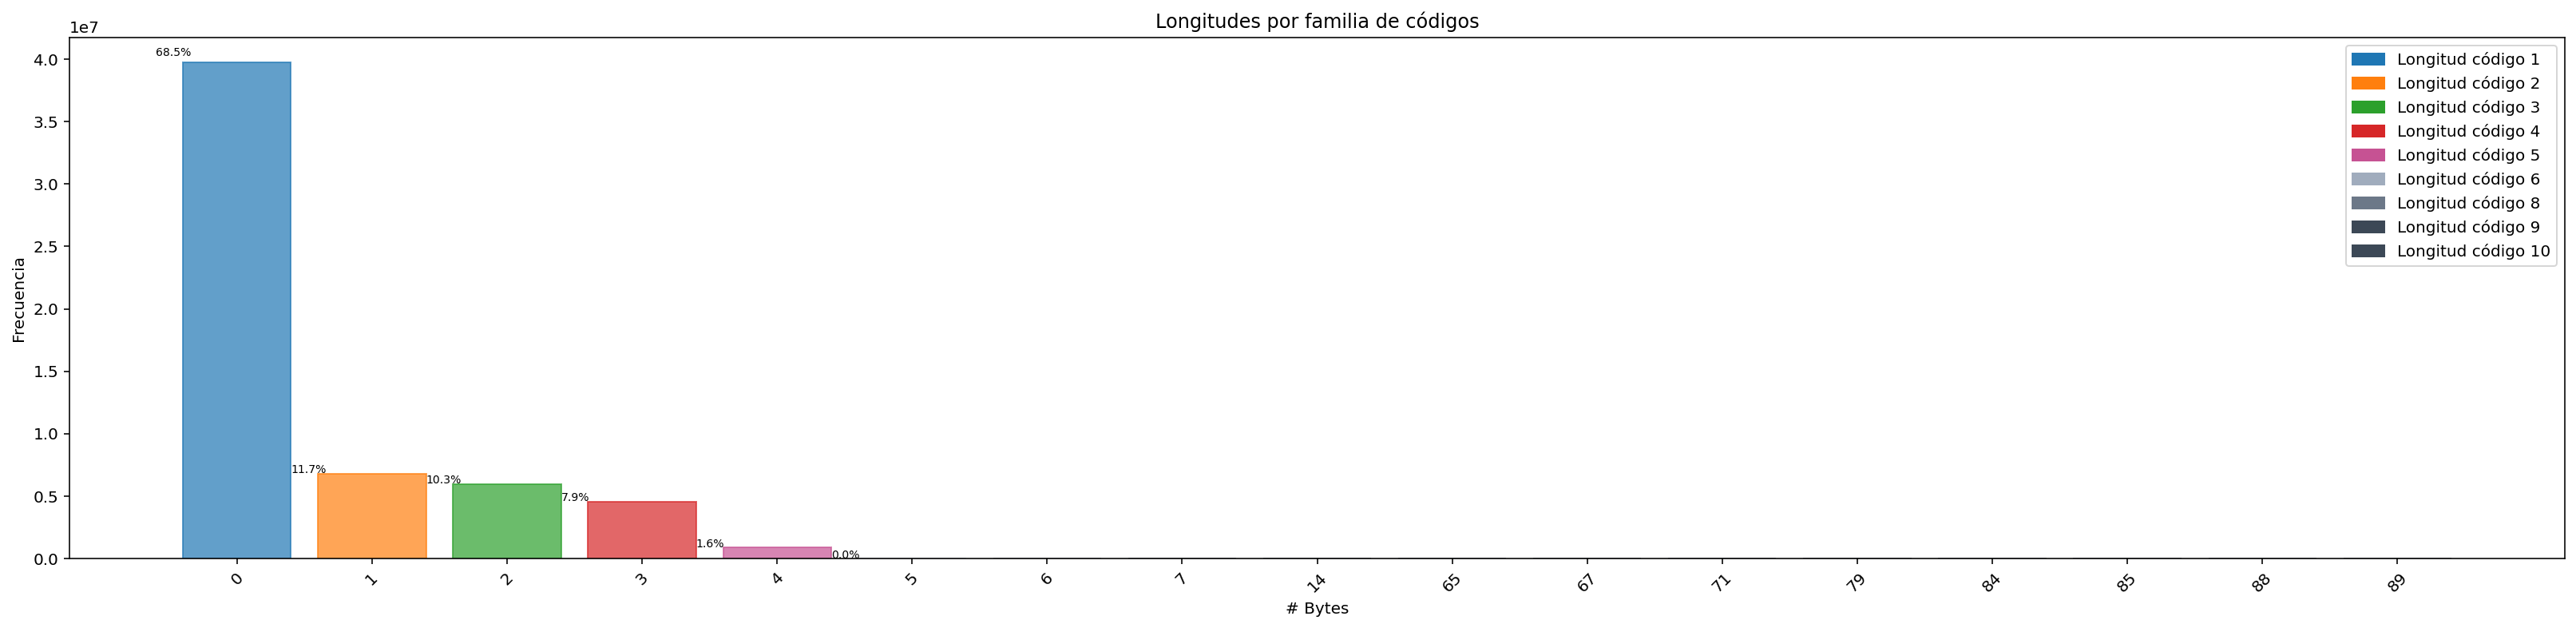

In [7]:
# palette = {"3": "#1f77b4", "4": "#ff7f0e", "5": "#2ca02c", "6": "#d62728", "7": "#9467bd", 
#            "8": "#8c564b", "9": "#e377c2", "10": "#7f7f7f", "11": "#bcbd22", "12": "#22bcbd", "13": "#bcbd22", "14": "#bcbd22", "15": "#bcbd22"}

palette = {"1": "#1F77B4", "2": "#ff7f0e", "3": "#2ca02c", "4": "#d62728", "5": "#C65293",
            "6": "#A0ACBD", "8": "#6C7888", "9": "#3C4856", "10": "#3C4856"} #12": "#3C4856", "13": "#3C4856", "14": "#3C4856", "15": "#3C4856",
        #    "16": "#3C4856", "17": "#3C4856", "18": "#3C4856","19": "#3C4856","20": "#3C4856","24": "#3C4856","25": "#3C4856","26": "#3C4856"}           

plot_lens_by_codes_families(h.tablefrequency, h.huffmancodes)           


# **LOOKUP TABLE**

In [9]:
start_time = timeit.default_timer()
ld = lookup_decoding(h.compressedFile, ht_inv)
decompressed, failslookup, successlookup =  ld.decode()

elapsed = timeit.default_timer() - start_time
print("elapsed time: ", elapsed, 's')

accuracy, total_attempts =  get_accuracy(failslookup, len(decompressed))

print("total_attempts: ", total_attempts, "accuracy:", accuracy, '%' )


elapsed time:  42.33237159999999 s
total_attempts:  36187204 accuracy: 76.4068 %


# **MARKOV CHAIN MODEL**

In [ ]:
def window(seq, n=2):

    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

pairs = pd.DataFrame(window(successlookup), columns=['state1', 'state2'])
counts = pairs.groupby('state1')['state2'].value_counts()
probs = (counts / counts.sum()).unstack()
probs = probs.fillna(0)
tmx = probs.to_numpy()

p = np.array(tmx) 

lengths.sort(reverse = False)

start_time = timeit.default_timer()
ld = MKC_decoding(h.compressedFile, ht_inv, lengths, p)
decompressed, failsmarkov, successmarkov =  ld.decode()

elapsed = timeit.default_timer() - start_time
print("elapsed time: ", elapsed, 's')

accuracy, total_attempts =  get_accuracy(failsmarkov, len(decompressed))

print("total_attempts: ", total_attempts, "accuracy:", accuracy, '%' )

# **CODE LENGTH without order**

In [13]:
random.shuffle(lengths)

start_time = timeit.default_timer()
ld = length_code_decoding(h.compressedFile, ht_inv, lengths)
decompressed, failsnoorder, successnoorder =  ld.decode()

elapsed = timeit.default_timer() - start_time
print("elapsed time: ", elapsed, 's')

accuracy, total_attempts =  get_accuracy(failsnoorder, len(decompressed))

print("total_attempts: ", total_attempts, "accuracy:", accuracy, '%' )


elapsed time:  72.6334308999999 s
total_attempts:  140548991 accuracy: 41.2843 %


# **CODE LENGTH with order**

In [15]:
lengths.sort(reverse = False)        

start_time = timeit.default_timer()
ld = length_code_decoding(h.compressedFile, ht_inv, lengths)
decompressed, failsorder, successorder =  ld.decode()

elapsed = timeit.default_timer() - start_time
print("elapsed time: ", elapsed, 's')

accuracy, total_attempts =  get_accuracy(failsorder, len(decompressed))

print("total_attempts: ", total_attempts, "accuracy:", accuracy, '%' )


elapsed time:  43.797458200000165 s
total_attempts:  36187189 accuracy: 76.4069 %


# **Order based in BYTES COMPRESSED**




In [16]:
nt = nt.sort_values(by=['Total Bytes'], ascending=False)

start_time = timeit.default_timer()
ld = information_decoding(h.compressedFile, ht_inv, list(nt["Longitud Código"]))
decompressed, failscompressed, successcompressed =  ld.decode()

elapsed = timeit.default_timer() - start_time
print("elapsed time: ", elapsed, 's')

accuracy, total_attempts =  get_accuracy(failscompressed, len(decompressed))

print("total_attempts: ", total_attempts, "accuracy:", accuracy, '%' )
nt

elapsed time:  39.18853940000008 s
total_attempts:  36187180 accuracy: 76.4069 %


,Longitud Código,Numero de Códigos,Total Bytes
1,1,1,39754513
2,2,1,6786356
3,3,1,5981077
4,4,1,4572900
5,5,1,929145
6,6,1,658
10,10,8,8
8,8,1,4
9,9,2,3


# **FAILURE BEHAVIOR**

1.431 fallos/byte con desviación estándar: 1.2881


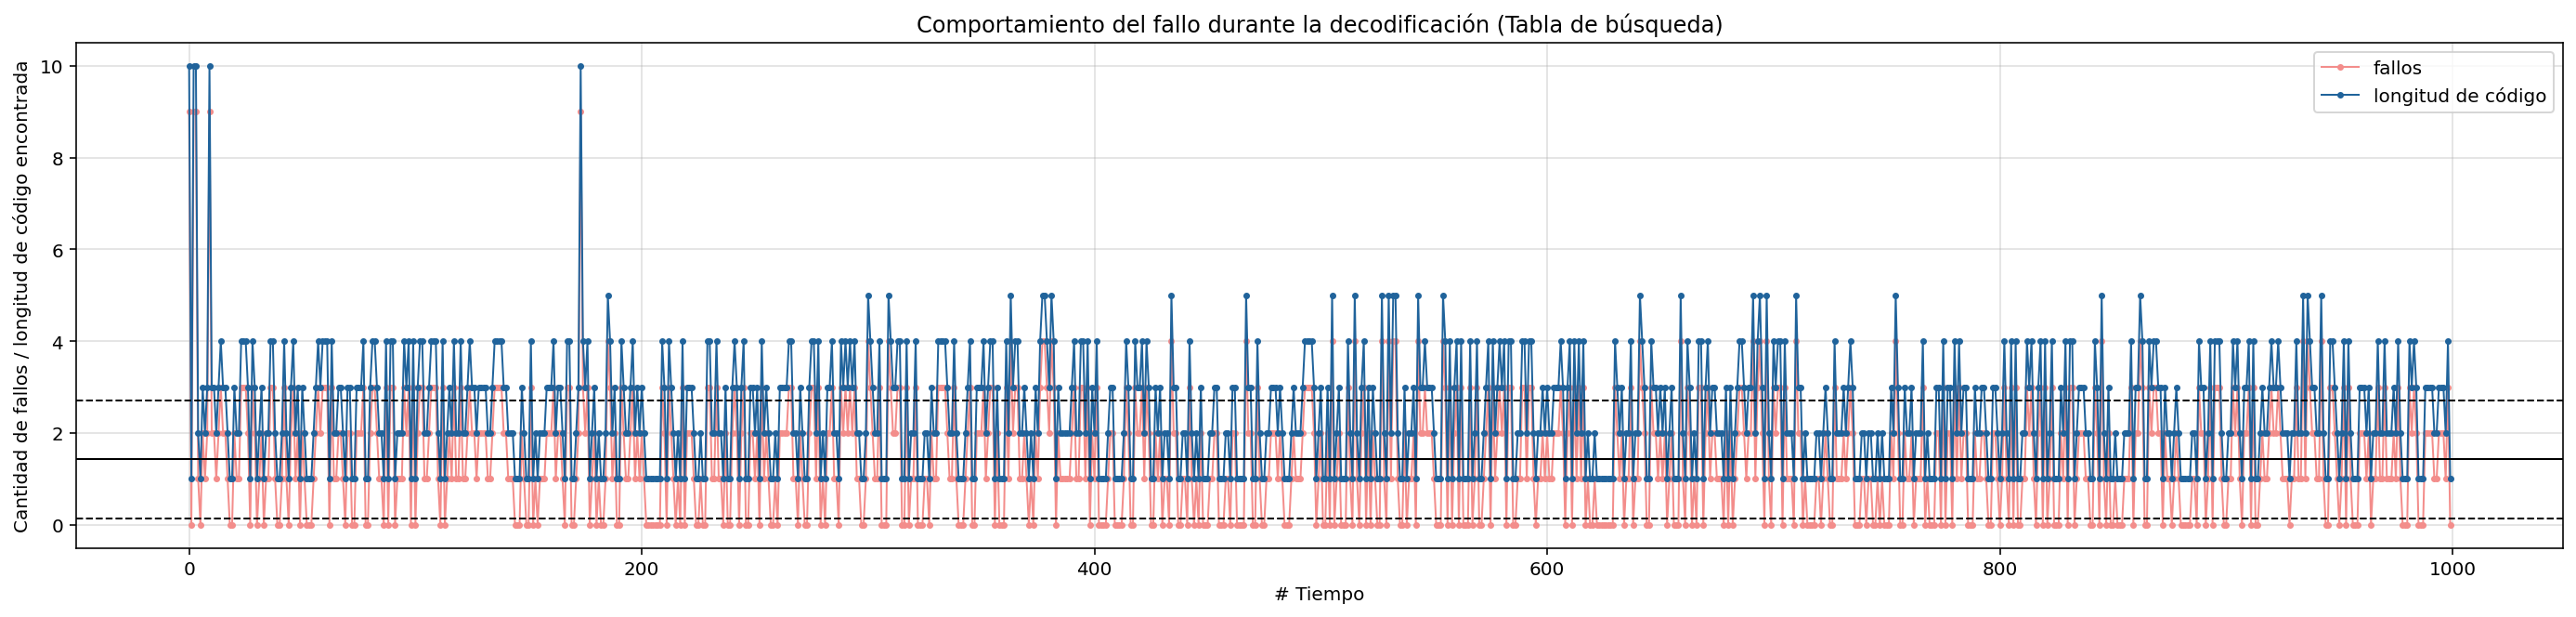

2.947 fallos/byte con desviación estándar: 1.899


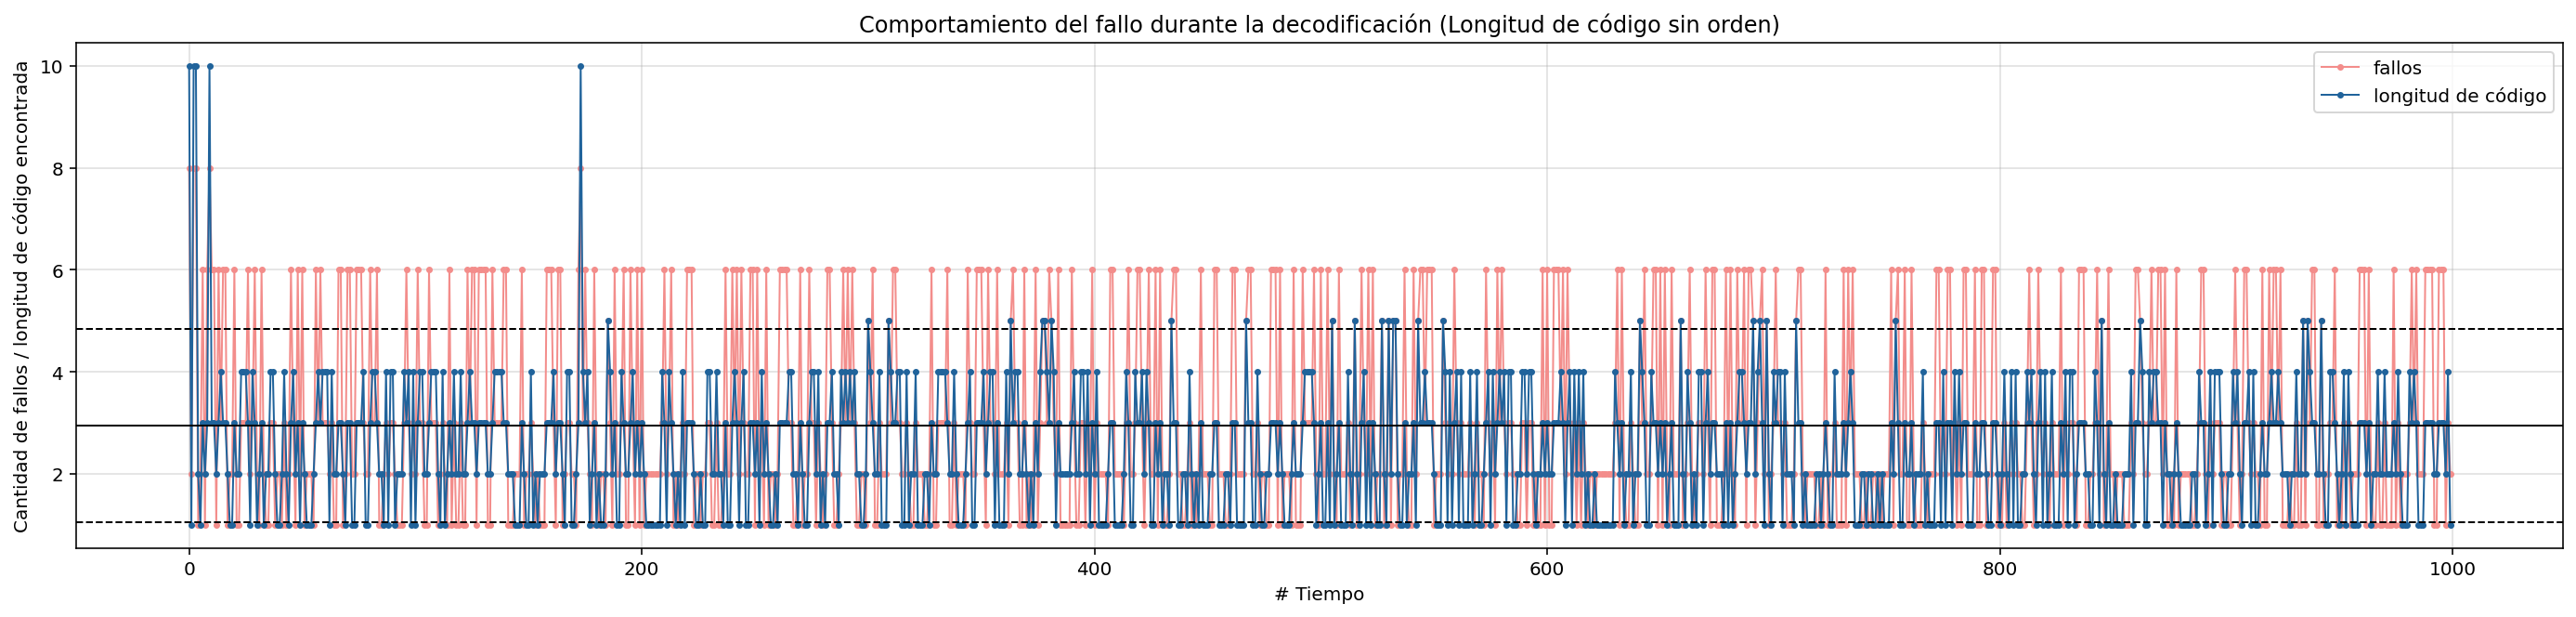

1.426 fallos/byte con desviación estándar: 1.2604


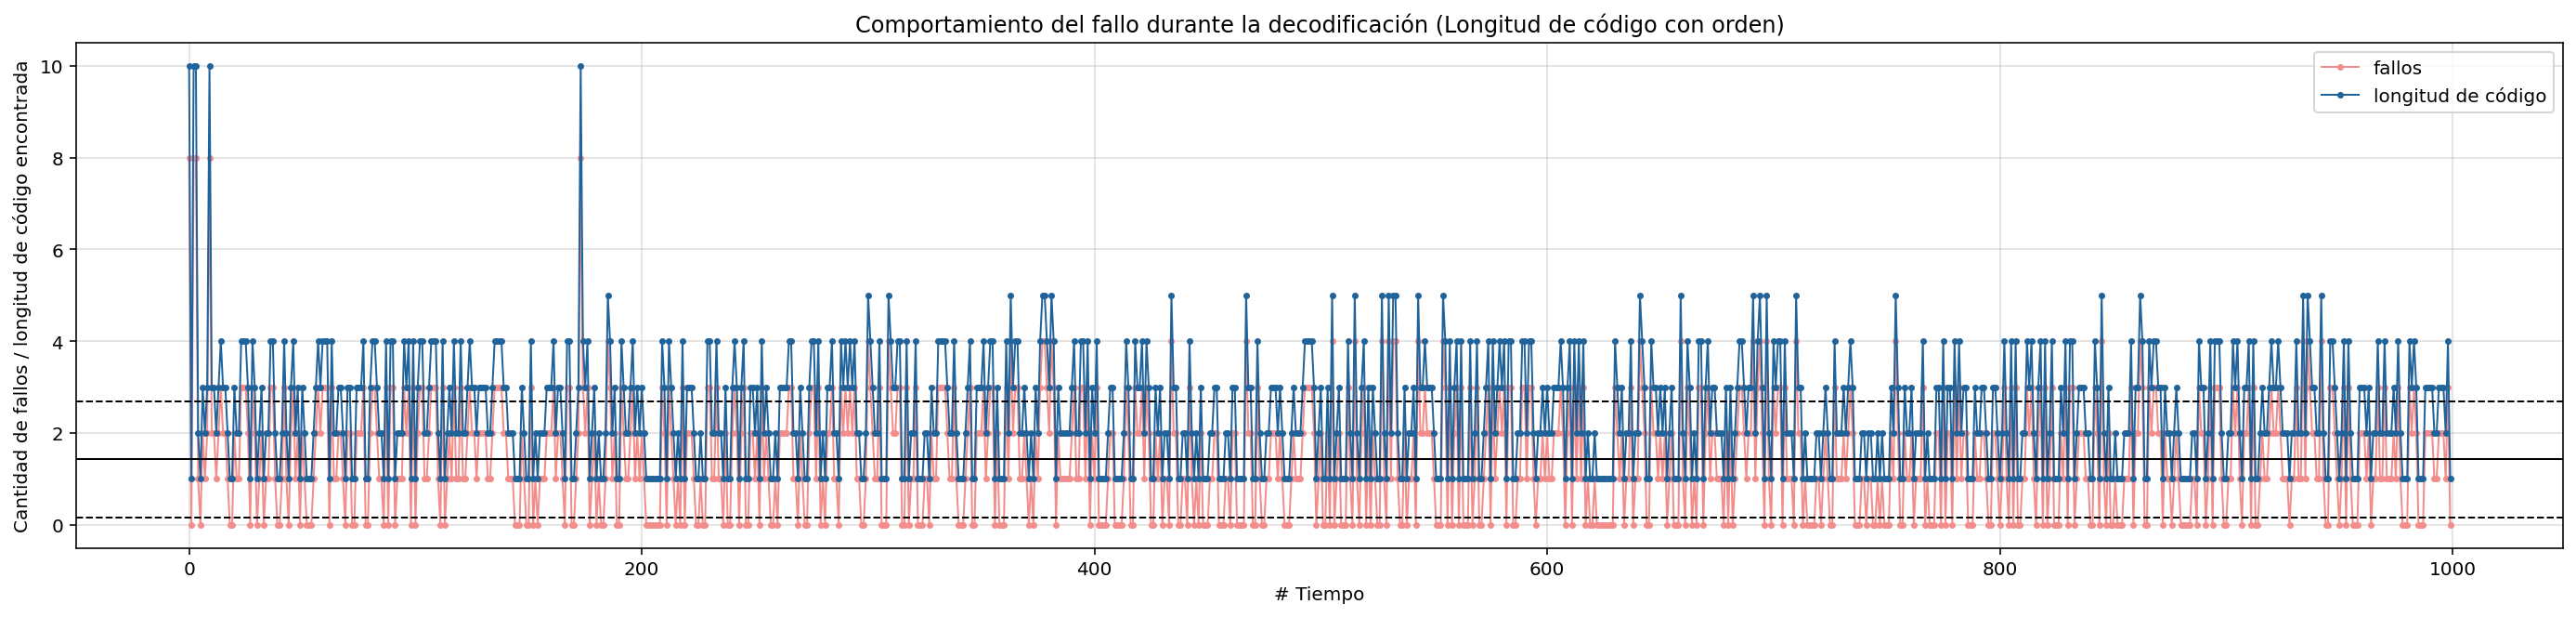

1.416 fallos/byte con desviación estándar: 1.2153


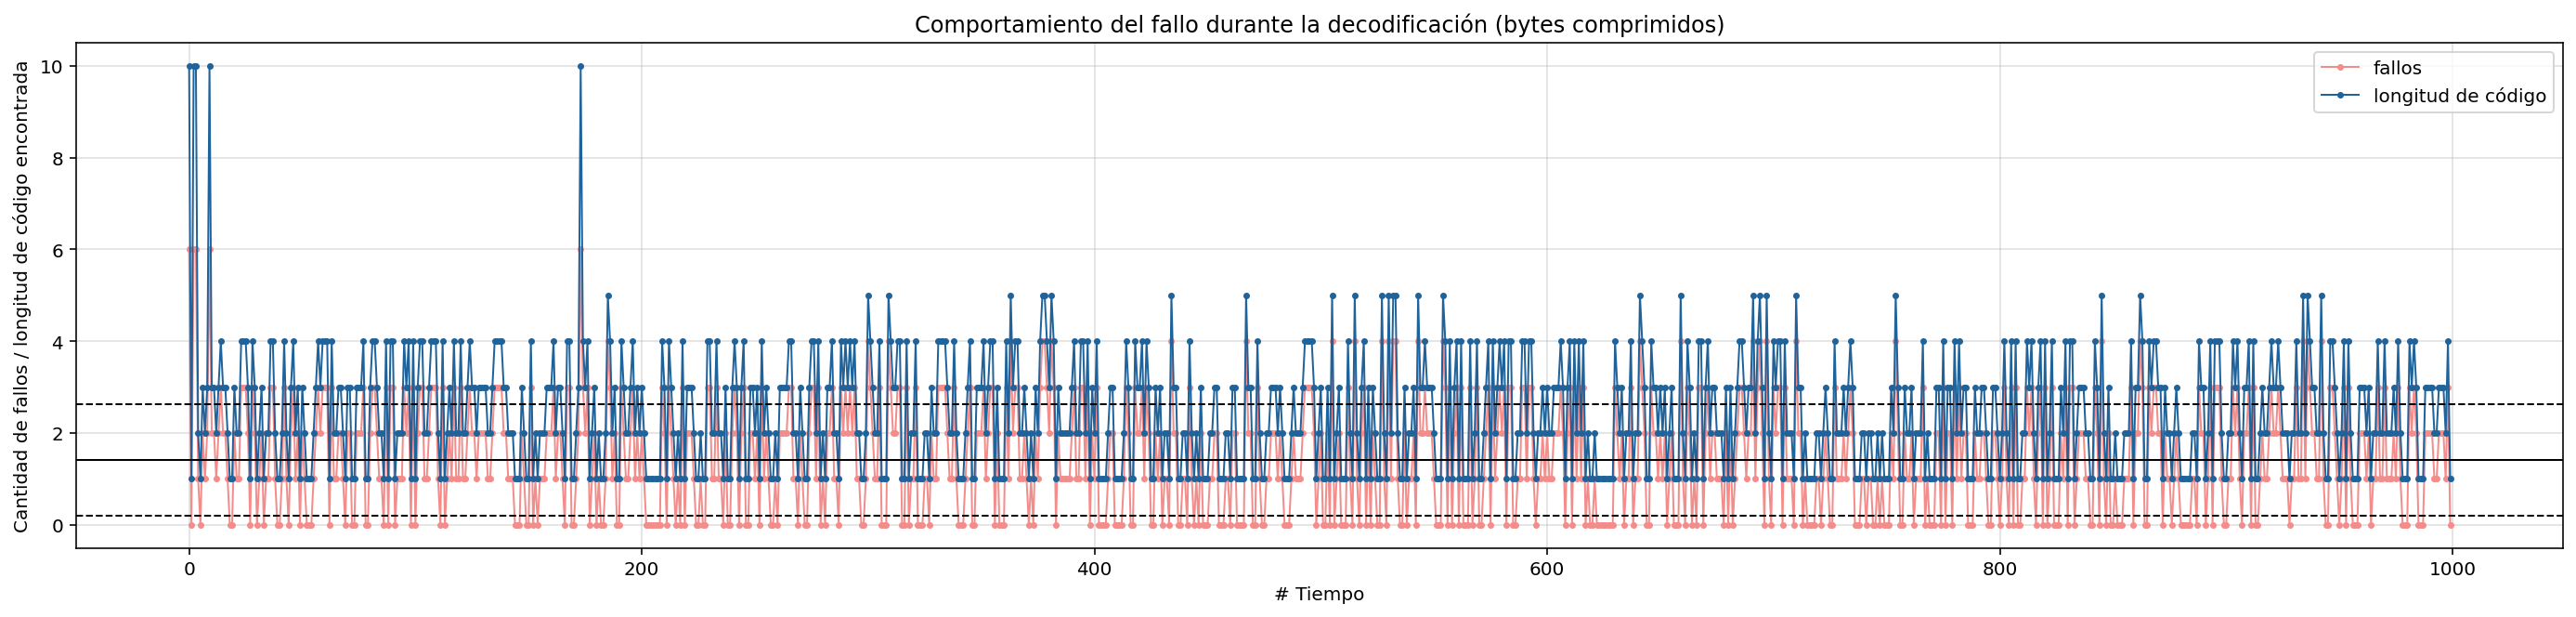

In [18]:
plot_fails_trend(failslookup[0:1000], successlookup[0:1000], 'Tabla de búsqueda')
plot_fails_trend(failsnoorder[0:1000], successnoorder[0:1000], 'Longitud de código sin orden')
plot_fails_trend(failsorder[0:1000], successorder[0:1000], 'Longitud de código con orden')
plot_fails_trend(failscompressed[0:1000], successcompressed[0:1000], 'bytes comprimidos')

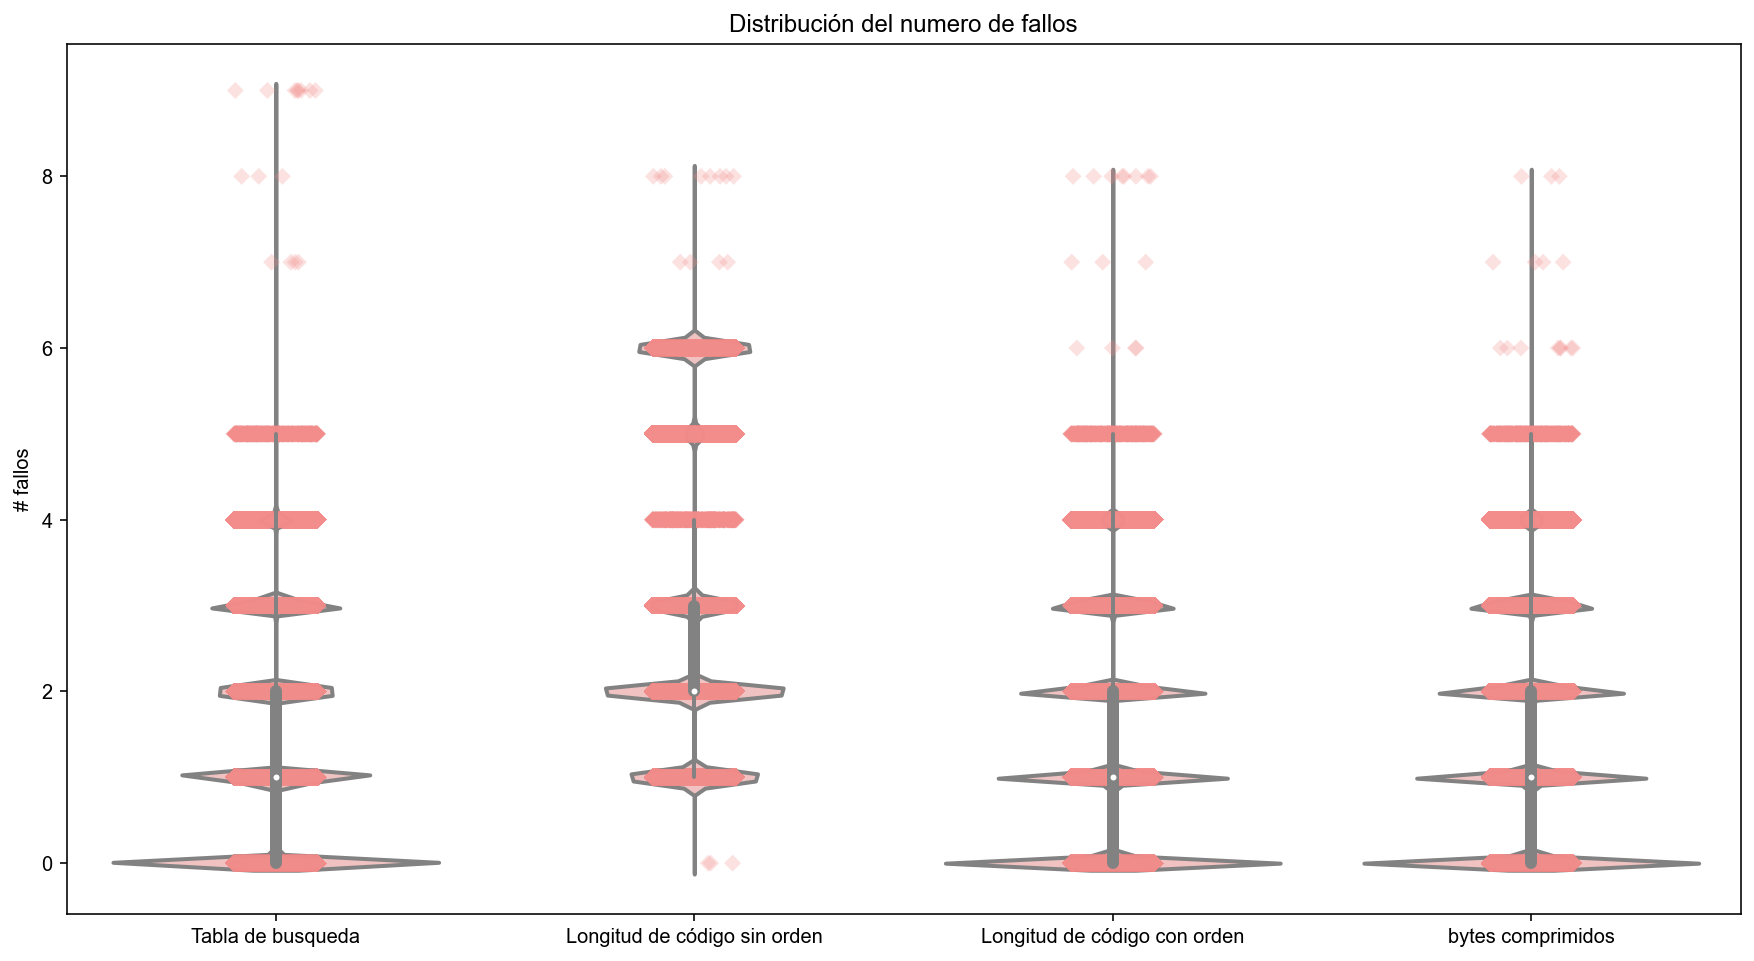

In [19]:
violindf = pd.DataFrame(list(zip(failslookup[0:20000000], failsnoorder[0:20000000], failsorder[0:20000000], failscompressed[0:20000000])),
                            columns=['Tabla de busqueda', 'Longitud de código sin orden',
                                    'Longitud de código con orden','bytes comprimidos'])

violindf = violindf.melt(var_name='algorithm', value_name='fails')

plot_fails_violin(violindf, 'algorithm', 'fails')

In [25]:
table_distlookup = table_fails_dist(failslookup)
table_distnoorder = table_fails_dist(failsnoorder)
table_distorder = table_fails_dist(failsorder)
table_distcompressed = table_fails_dist(failscompressed)

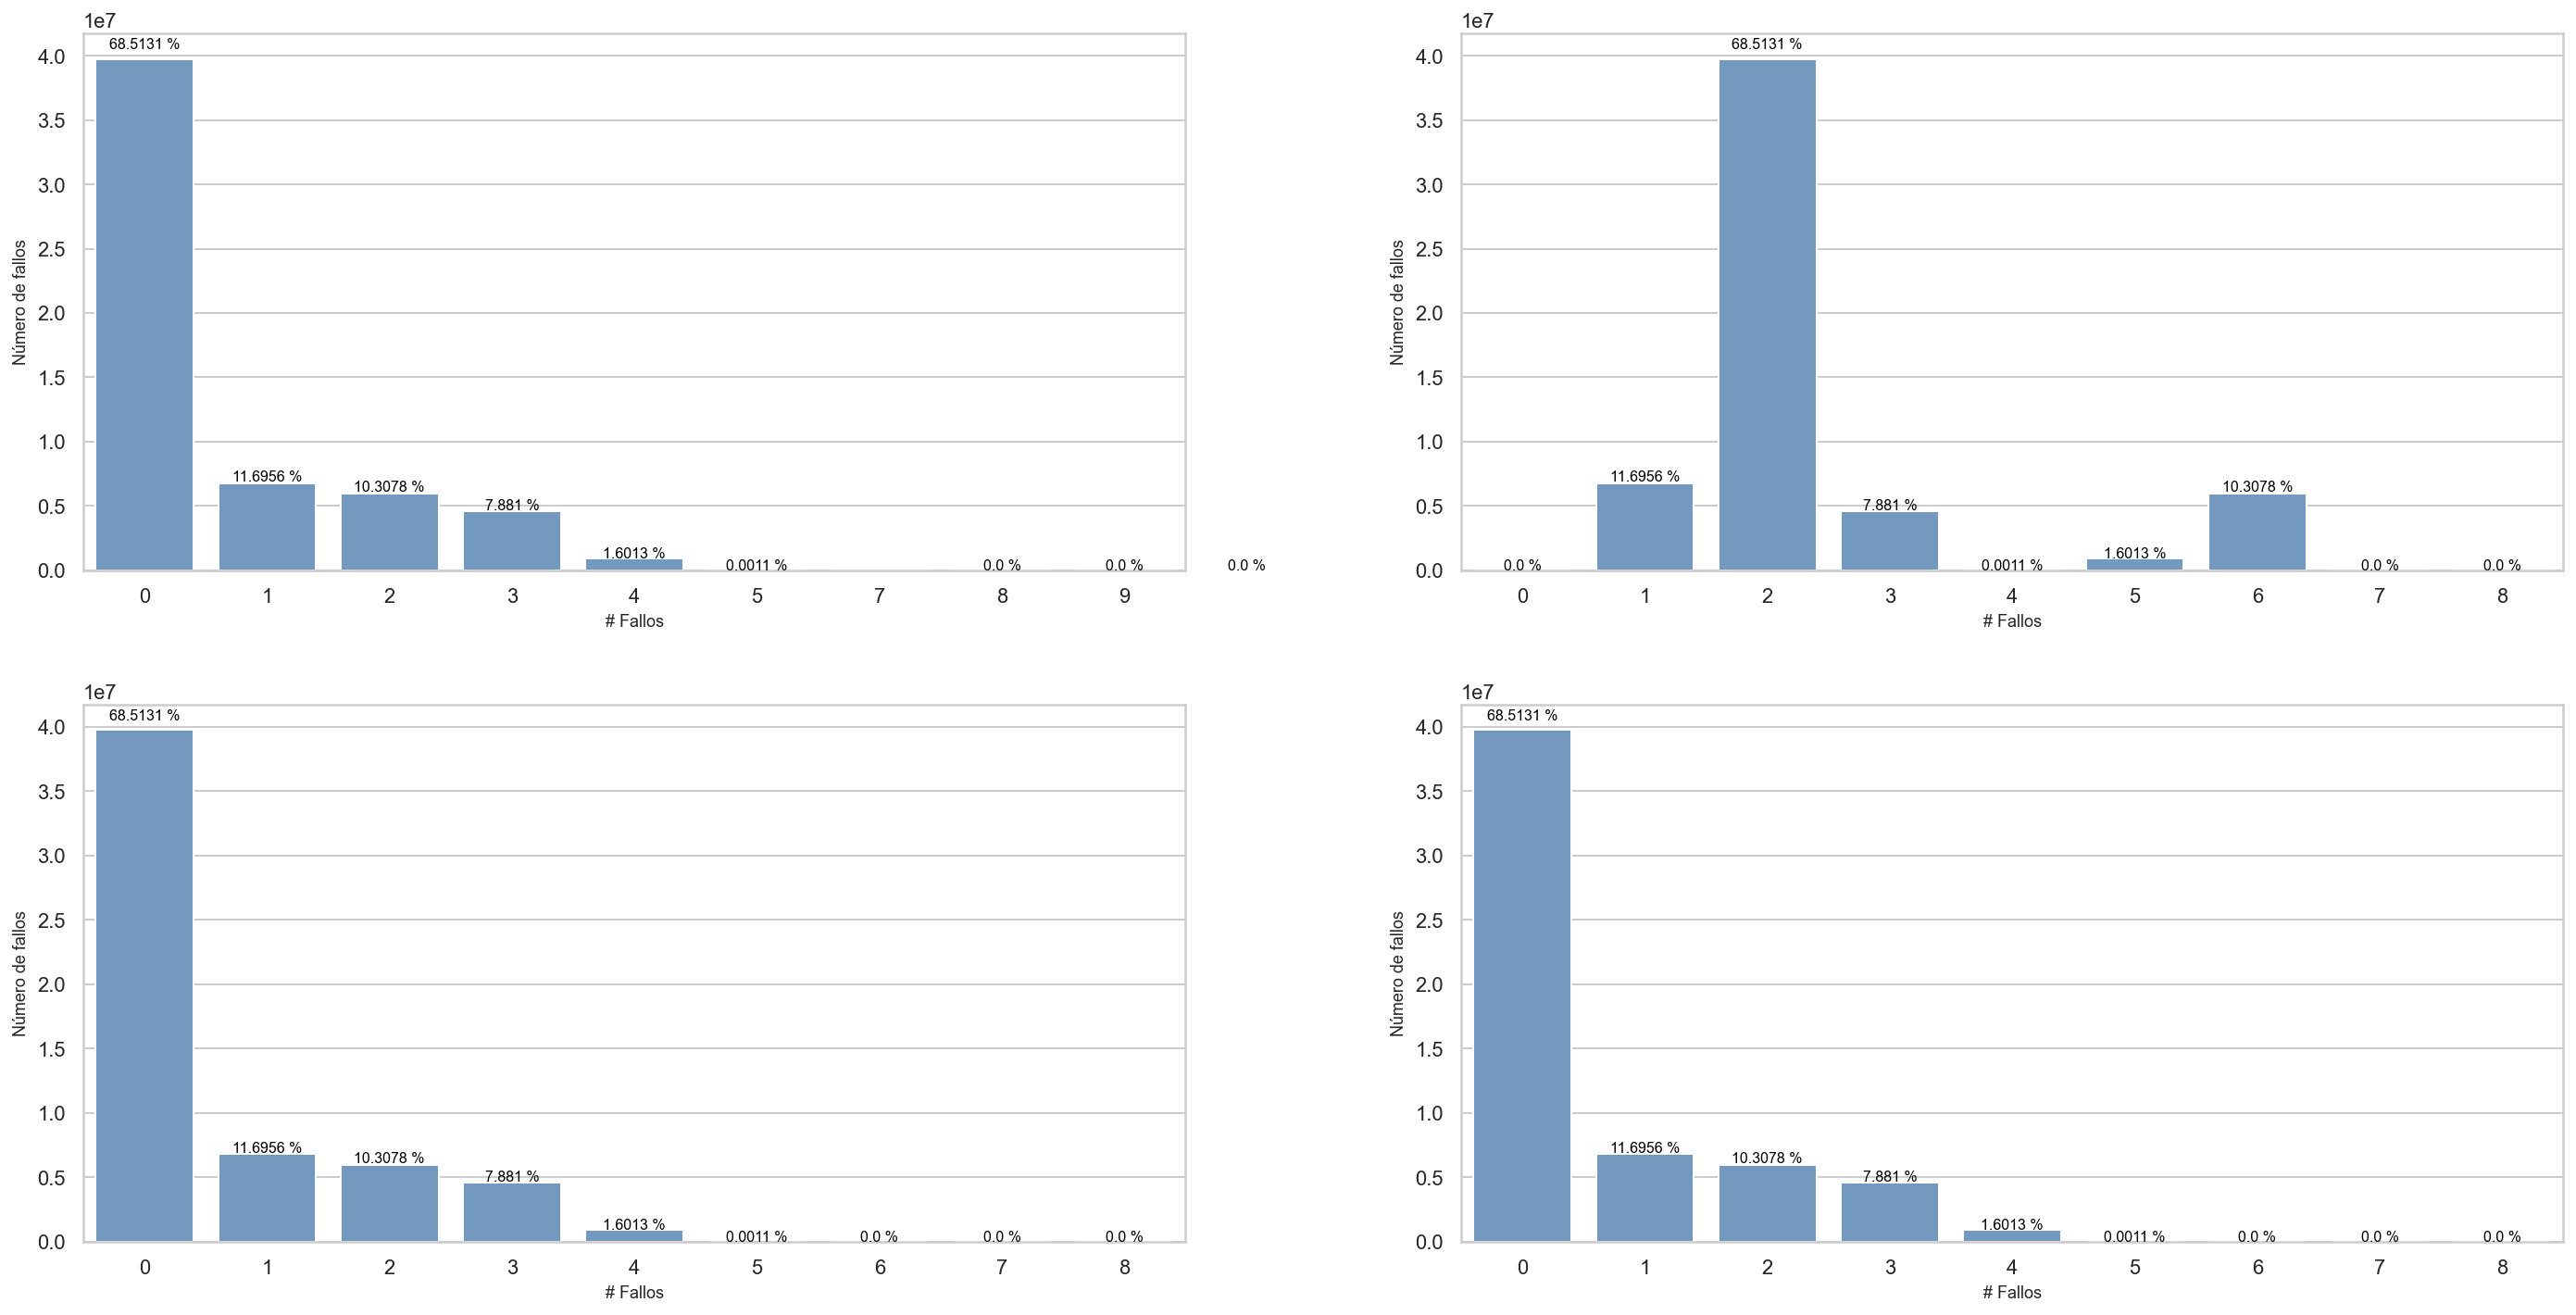

In [26]:
plot_fails_dist(table_distlookup, table_distnoorder, table_distorder,  table_distcompressed)